In [1]:
#### Load multiple time series
# import all modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
fig1 = plt.figure(figsize=(2, 2), dpi=100)
%config InlineBackend.figure_format = 'retina'
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
# Import data
print("Reading in data...")
filepath = "C:/Users/Lenovo/Desktop/Rental/airbnb/reviews.csv.gz"
df= pd.read_csv(filepath, header=0, index_col=None)
print(df.head(5))
# Check the type of each column in your DataFrame
print(df.dtypes)

Reading in data...
   listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  
0  Having the opportunity of arriving to Alexandr...  
1  We have no enough words to describe how beauty...  
2  The listing was exceptional and an even better...  
3  Alexandra's home was amazing and in such a nea...  
4  Beautiful home. Very comfortable and clean. Pe...  
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


<Figure size 200x200 with 0 Axes>

In [2]:
import numpy as np
import pandas as pd
import os
import string
from sklearn.model_selection import train_test_split
import tensorflow 
import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, LSTM, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import datetime
import math


Using TensorFlow backend.


In [3]:
def load_airbnb_datasets():
    '''
    Run this if you need to load in the Boston Airbnb datasets
    '''
    df_listings = pd.read_csv('C:/Users/Lenovo/Desktop/Rental/airbnb/listings.csv')
    df_reviews = pd.read_csv('C:/Users/Lenovo/Desktop/Rental/airbnb/reviews.csv.gz')
    df_calendar = pd.read_csv('C:/Users/Lenovo/Desktop/Rental/airbnb/calendar/calendar_jan_2019.csv.gz')
    df_reviews= df_reviews[np.isfinite(df_reviews['id'])]
    df_reviews= df_reviews[np.isfinite(df_reviews['listing_id'])]
    df_reviews= df_reviews.dropna(how='any')
    df_reviews[df_reviews == 'NA'] = np.nan
    df_reviews.isnull().sum()
    return df_calendar, df_listings, df_reviews
df_calendar, df_listings, df_reviews = load_airbnb_datasets()

C:\Users\Lenovo\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3209: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\Lenovo\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
print(df_reviews.head(50))

    listing_id         id        date  reviewer_id    reviewer_name  \
0         1419   38924112  2015-07-19     11308465          Marcela   
1         1419   44791978  2015-08-29      9580285            Marco   
2         1419   45957133  2015-09-07     38394721           Andrea   
3         1419   67295154  2016-03-28      3515044            Shaun   
4         1419  177702208  2017-08-03     13987100             Kate   
5         1419  179394665  2017-08-07    111148735          Melissa   
6         1419  216619832  2017-12-04     46323833           Rachel   
7         8077       7830  2009-08-20        12750        Margarita   
8         8077       9941  2009-09-13        30020            Sunny   
9         8077      11995  2009-09-30        36786   Collin & Nandi   
10        8077      12177  2009-10-02        36703            Wendy   
11        8077      18294  2009-11-25         7386         Adrienne   
12        8077      18890  2009-11-30        57824          Michele   
13    

In [5]:
ids, counts = np.unique(df_reviews['listing_id'], return_counts = True)
print('Minimum number of reviews: ' + str(min(counts)))
print('Maximum number of reviews: ' + str(max(counts)))

Minimum number of reviews: 1
Maximum number of reviews: 677


In [6]:
gt_100 = np.where(counts > 10)[0]
ids_gt_100 = ids[gt_100]

print('Number of listings with greater than 100 reviews: ' + str(len(gt_100)))
print('\nIndices of listings with greater than 100 reviews:\n' + str(gt_100))
print('\nAssociated listings with greater than 100 reviews:\n' + str(ids_gt_100))

Number of listings with greater than 100 reviews: 8502

Indices of listings with greater than 100 reviews:
[    1     2     3 ... 15892 15901 15936]

Associated listings with greater than 100 reviews:
[    8077    23691    26654 ... 32201920 32232905 32317104]


In [7]:
def strip_punctuation_and_whitespace(reviews_df, verbose = True):
    '''
    Strips all punctuation and whitespace from reviews EXCEPT spaces (i.e. ' ')
    Removes "<br />"
    Returns dataframe of cleaned IMDB reviews
    '''
    trans_punc = str.maketrans(string.punctuation,
                               ' ' * len(string.punctuation))
    whitespace_except_space = string.whitespace.replace(' ', '')
    trans_white = str.maketrans(whitespace_except_space,
                                ' ' * len(whitespace_except_space))
    stripped_df = pd.DataFrame(columns = ['review', 'sentiment'])
    for i, row in enumerate(reviews_df.values):
        if i % 5000 == 0 and verbose == True:
            print('Stripping review: ' + str(i) + ' of ' + str(len(reviews_df)))
        if type(reviews_df) == pd.DataFrame:
            review = row[0]
            sentiment = row[1]
        elif type(reviews_df) == pd.Series:
            review = row
            sentiment = np.NaN
        try:
            review.replace('<br />', ' ')
            for trans in [trans_punc, trans_white]:
                review = ' '.join(str(review).translate(trans).split())
            combined_df = pd.DataFrame([[review, sentiment]],
                                       columns = ['review', 'sentiment'])
            stripped_df = pd.concat([stripped_df, combined_df],
                                    ignore_index = True)
        except AttributeError:
            continue
    return stripped_df

In [8]:
def get_length_all_reviews(sentences):
    '''
    Returns a list of length of all reviews
    Used for plotting histogram
    '''
    lengths = [len(i.split(' ')) for i in sentences]
    return lengths

In [9]:
def create_tokenizer(max_words_to_keep, words_review_df):
    '''
    Creates tokenizer
    Returns a tokenizer object and reviews converted to integers
    '''
    tokenizer = Tokenizer(num_words = max_words_to_keep,
                          lower = True,
                          split = ' ')
    tokenizer.fit_on_texts(words_review_df['review'].values)
    return tokenizer, \
           tokenizer.texts_to_sequences(words_review_df['review'].values)
imdb_sequence_length = 500
vocabulary_length = 500

In [10]:
def pad_zeros(encoded_reviews, padding_length, padding = 'pre'):
    '''
    Pads integer reviews either left ('pre') or right ('post')
    '''
    return pad_sequences(encoded_reviews,
                         maxlen = padding_length,
                         padding = padding)

In [ ]:
def create_LSTM_model(vocab_length, in_length, opt = 'Adagrad',
                      learning_rate = 0.01):
    ''''
    Returns 1-layer LSTM model
    '''
    model = Sequential()
    model.add(Embedding(vocab_length, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = getattr(keras.optimizers, opt)(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

LSTM_model = create_LSTM_model(vocabulary_length,
                               imdb_sequence_length,
                               opt = 'Adagrad',
                               learning_rate = 0.01)
print(LSTM_model.summary())

In [23]:
ratings = {}

for temp_id in ids_gt_100:
    temp_comments = df_reviews.loc[df_reviews['listing_id'] == \
                                   temp_id]['comments']
    
    # Rename for function, then strip punctuation and whitespace
    temp_comments.rename('review', inplace = True)
    stripped_airbnb = strip_punctuation_and_whitespace(temp_comments,
                                                       verbose = False)
    
    # Plot histogram of review length. Find sequence cutoff length
    airbnb_lengths = get_length_all_reviews(stripped_airbnb['review'])
    #plot_histogram(airbnb_lengths, 1000)
    airbnb_sequence_length =1000
    
    # Tokenizer with 10000 word vocabulary
    airbnb_tokenizer, airbnb_integer_reviews = \
                                            create_tokenizer(vocabulary_length,
                                                             stripped_airbnb)
    # Pad zeros up to airbnb_sequence_length
    airbnb_padded_reviews = pad_zeros(airbnb_integer_reviews,
                                      airbnb_sequence_length,
                                      padding = 'pre')
    
    # Predict sentiment
    airbnb_sentiments = LSTM_model.predict_classes(airbnb_padded_reviews)
    predicted_rating = round(airbnb_sentiments.mean() * 100, 1)

    # Print comparisons
    actual_rating = df_listings.loc[df_listings['id'] == temp_id]\
                    ['review_scores_rating'].values[0]
    print('--- Listing ID ' + str(temp_id) + ' ---\nPredicted Rating: [' + \
          str(predicted_rating) + '] vs. Actual Rating: [' + \
          str(actual_rating) + ']')
    ratings[temp_id] = [actual_rating, predicted_rating]

--- Listing ID 8077 ---
Predicted Rating: [40.2] vs. Actual Rating: [97.0]
--- Listing ID 23691 ---
Predicted Rating: [48.3] vs. Actual Rating: [95.0]
--- Listing ID 26654 ---
Predicted Rating: [61.1] vs. Actual Rating: [95.0]
--- Listing ID 27423 ---
Predicted Rating: [34.6] vs. Actual Rating: [98.0]
--- Listing ID 40456 ---
Predicted Rating: [27.6] vs. Actual Rating: [92.0]
--- Listing ID 41887 ---
Predicted Rating: [47.4] vs. Actual Rating: [94.0]
--- Listing ID 43964 ---
Predicted Rating: [48.0] vs. Actual Rating: [99.0]
--- Listing ID 44452 ---
Predicted Rating: [48.9] vs. Actual Rating: [77.0]
--- Listing ID 45399 ---
Predicted Rating: [52.3] vs. Actual Rating: [80.0]
--- Listing ID 45893 ---
Predicted Rating: [29.4] vs. Actual Rating: [84.0]
--- Listing ID 50110 ---
Predicted Rating: [55.0] vs. Actual Rating: [92.0]
--- Listing ID 51616 ---
Predicted Rating: [33.3] vs. Actual Rating: [98.0]
--- Listing ID 64003 ---
Predicted Rating: [53.8] vs. Actual Rating: [96.0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
split = 0.7
X_train, X_test, y_train, y_test = train_test_split( airbnb_padded_reviews,
                                                    stripped_airbnb['sentiment'],
                                                    test_size = split,
                                                    random_state = 70)

In [15]:
ep = 10
LSTM_history = LSTM_model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              batch_size = 10, epochs = ep, verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 4 samples, validate on 11 samples
Epoch 1/10
4/4 [==============================] - 3s 711ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 1s 192ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 1s 197ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 1s 200ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 1s 196ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 1s 194ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 1s 197ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_a

In [ ]:
plt.plot(range(10), LSTM_history.history['val_acc'], '--o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy After {} Epochs'.format(ep))
plt.show()

In [24]:
sorted_ratings = [ratings[i] for i in ratings]
sorted_ratings.sort()
sorted_ratings

[[77.0, 48.9],
 [80.0, 52.3],
 [84.0, 29.4],
 [92.0, 27.6],
 [92.0, 55.0],
 [94.0, 47.4],
 [95.0, 48.3],
 [95.0, 61.1],
 [96.0, 53.8],
 [97.0, 40.2],
 [98.0, 33.3],
 [98.0, 34.6],
 [99.0, 48.0]]

In [25]:
plot_actual_ratings = [rating[0] for rating in sorted_ratings]
plot_predicted_ratings = [rating[1] for rating in sorted_ratings]

print('First 10 Actual Ratings: \n' + str(plot_actual_ratings[0:10]))
print('\nFirst 10 Predicted Ratings: \n' + str(plot_predicted_ratings[0:10]))

First 10 Actual Ratings: 
[77.0, 80.0, 84.0, 92.0, 92.0, 94.0, 95.0, 95.0, 96.0, 97.0]

First 10 Predicted Ratings: 
[48.9, 52.3, 29.4, 27.6, 55.0, 47.4, 48.3, 61.1, 53.8, 40.2]


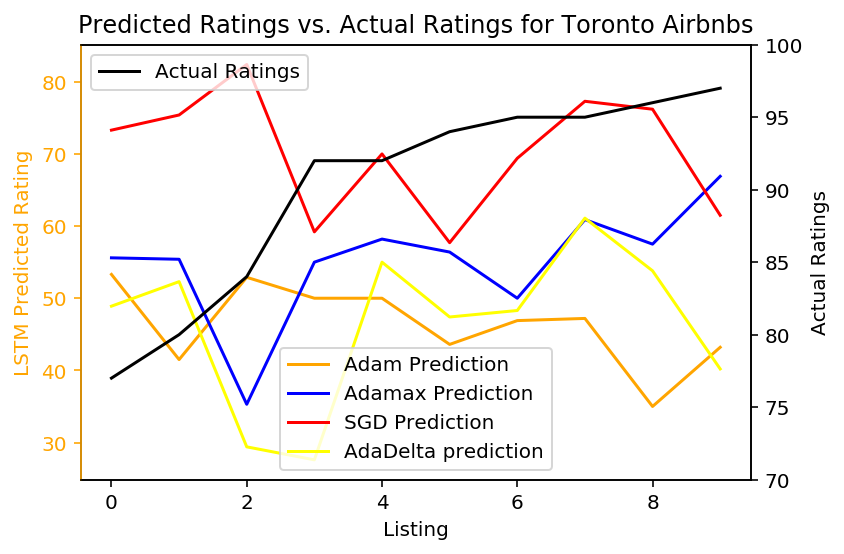

In [37]:
plot_actual_ratings = [77.0, 80.0, 84.0, 92.0, 92.0, 94.0, 95.0, 95.0, 96.0, 97.0]
plot_predicted_ratings_adam = [53.3, 41.5, 52.9, 50.0, 50.0, 43.6, 46.9, 47.2, 35.0, 43.2]
plot_predicted_ratings_adamax = [55.6, 55.4, 35.3, 55.0, 58.2, 56.4, 50.0, 60.9, 57.5, 66.9]
plot_predicted_ratings_SGD = [73.3, 75.4, 82.4, 59.2, 70.0, 57.7, 69.4, 77.3, 76.2, 61.5]
plot_predicted_ratings_Adadelta = [48.9, 52.3, 29.4, 27.6, 55.0, 47.4, 48.3, 61.1, 53.8, 40.2]

ax1_min = int(math.floor(min(plot_predicted_ratings_SGD)/5) * 5)

fig, ax1 = plt.subplots()
predicted_line = ax1.plot(range(len(plot_predicted_ratings_adam)),
                          plot_predicted_ratings_adam,
                          color = 'orange',
                          label = 'Adam Prediction')
predicted_line = ax1.plot(range(len(plot_predicted_ratings_adamax)),
                          plot_predicted_ratings_adamax,
                          color = 'blue',
                          label = 'Adamax Prediction')
predicted_line = ax1.plot(range(len(plot_predicted_ratings_SGD)),
                          plot_predicted_ratings_SGD,
                          color = 'red',
                          label = 'SGD Prediction')
predicted_line = ax1.plot(range(len(plot_predicted_ratings_Adadelta)),
                          plot_predicted_ratings_Adadelta,
                          color = 'yellow',
                          label = 'AdaDelta prediction')
ax1.set_xlabel('Listing')
ax1.set_ylabel('LSTM Predicted Rating', color = 'orange')
ax1.tick_params(axis = 'y', color = 'orange')
plt.setp(ax1.get_yticklabels(), color = 'orange')


ax2 = ax1.twinx()
actual_line = ax2.plot(range(len(plot_actual_ratings)),
                       plot_actual_ratings,
                       color = 'black',
                       label = 'Actual Ratings')
ax2.set_ylabel('Actual Ratings', color = 'black')
ax2.set_ylim(70, 100)
ax2.spines['left'].set_color('orange')

ax1.legend()
ax2.legend()
plt.title('Predicted Ratings vs. Actual Ratings for Toronto Airbnbs')
plt.show()